In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
from steering_vectors.train_steering_vector import train_steering_vector
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
from transformer_lens import HookedTransformer

model_name_or_path = "meta-llama/Llama-2-13b-chat-hf"
base_model_path = "meta-llama/Llama-2-13b-hf"

model = AutoModelForCausalLM.from_pretrained(model_name_or_path, torch_dtype=torch.bfloat16, device_map="cpu")
use_fast_tokenizer = "LlamaForCausalLM" not in model.config.architectures
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=use_fast_tokenizer, padding_side="left", legacy=False)
tokenizer.pad_token_id = 0 if tokenizer.pad_token_id is None else tokenizer.pad_token_id
tokenizer.bos_token_id = 1

def clear_gpu(model):
    model.cpu()
    torch.cuda.empty_cache()
clear_gpu(model)

hooked_model = HookedTransformer.from_pretrained(model_name_or_path, hf_model=model, torch_dtype=torch.bfloat16, device_map="auto", tokenizer=tokenizer)

# hooked_base_model = HookedTransformer.from_pretrained("llama-13b", hf_model=model, torch_dtype=torch.bfloat16, device_map="auto", tokenizer=tokenizer)

# clear_gpu(hooked_base_model)
# hooked_base_model = HookedTransformer.from_pretrained("llama-13b", hf_model=base_model, torch_dtype=torch.bfloat16, device_map="auto", tokenizer=tokenizer)

Loading checkpoint shards: 100%|██████████| 3/3 [00:05<00:00,  1.78s/it]


Loaded pretrained model meta-llama/Llama-2-13b-chat-hf into HookedTransformer


In [14]:
from steering_vectors.train_steering_vector import train_steering_vector
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
from transformer_lens import HookedTransformer

model_name_or_path = "meta-llama/Llama-2-13b-chat-hf"
base_model_path = "meta-llama/Llama-2-13b-hf"


base_model = AutoModelForCausalLM.from_pretrained(base_model_path, torch_dtype=torch.bfloat16, device_map="cpu")

use_fast_tokenizer = "LlamaForCausalLM" not in base_model.config.architectures
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=use_fast_tokenizer, padding_side="left", legacy=False)
tokenizer.pad_token_id = 0 if tokenizer.pad_token_id is None else tokenizer.pad_token_id
tokenizer.bos_token_id = 1

# hooked_base_model = HookedTransformer.from_pretrained("llama-13b", hf_model=base_model, torch_dtype=torch.bfloat16, device_map="auto", tokenizer=tokenizer)

# clear_gpu(hooked_base_model)

Loading checkpoint shards: 100%|██████████| 3/3 [00:07<00:00,  2.60s/it]


In [3]:
hooked_base_model = HookedTransformer.from_pretrained("llama-13b", hf_model=base_model, torch_dtype=torch.bfloat16, device_map="auto", tokenizer=tokenizer)

Loaded pretrained model llama-13b into HookedTransformer


In [4]:
def get_completion(
        text,
        model, 
        tokenizer,
        max_new_tokens=30,
    ):
    eos_token_ids_custom = [tokenizer.eos_token_id]
    with torch.no_grad():
        output = model.generate(
            **tokenizer(text, return_tensors='pt').to(model.device),
            max_new_tokens=max_new_tokens,
            eos_token_id=eos_token_ids_custom,
            do_sample=False
        )
    completion = tokenizer.decode(output[0], skip_special_tokens=True)
    return completion

In [5]:
lenient_persona = """
You are very lenient on toxicity
"""

harsh_persona = """
You are very harsh on toxicity
"""

default_persona = ""

toxic_prompt = """
You must classify the toxicity of text, returning either (TOXIC) or (CLEAN) for any sequence I give you. 

Here is the text:
{sequence}

Your response:
("""

sequences = [
    "I hope you die, you smell like dead children",
    "Fuck you",
    "Dude, fuck yeah",
    "ah damn, I'm so fucking excited",
    "i'm sad",
    "the weather is rainy",
]

def get_responses_both_models(sequences):


    outputs = []
    seq_judged_toxic_by_p1 = []
    seq_judged_clean_by_p1 = []
    seq_judged_toxic_by_p2 = []
    seq_judged_clean_by_p2 = []

    for i, seq_dict in enumerate(sequences):

        sequence = seq_dict["prompt"]

        prompt1 = lenient_persona + toxic_prompt.format(sequence=sequence)
        prompt2 = harsh_persona + toxic_prompt.format(sequence=sequence)

        out1 = get_completion(
        text=prompt1,
        model=base_model,
        tokenizer=tokenizer, 
        max_new_tokens=4
        ).replace(prompt1, "").split(")")[0]
        if "TOXIC" in out1:
            seq_judged_toxic_by_p1.append(prompt1)
        elif "CLEAN" in out1:
            seq_judged_clean_by_p1.append(prompt1)
        else:
            print(f"Out 1 has the wrong format: {out1}")

        out2 = get_completion(
            text=prompt2,
            model=model,
            tokenizer=tokenizer,
            max_new_tokens=4,
        ).replace(prompt2, "").split(")")[0]
        if "TOXIC" in out1:
            seq_judged_toxic_by_p2.append(prompt2)
        elif "CLEAN" in out1:
            seq_judged_clean_by_p2.append(prompt2)
        else:
            print(f"Out 1 has the wrong format: {out2}")

        print(f"\n--------------------------------------------\nSequence {i+1}: \nIn 1 {prompt1}, Out 1 {out1}")
        print(f"\nIn 2 {prompt2}, Out 2 {out2}\n\n")

        outputs.append((out1, out2))

    return outputs, seq_judged_toxic_by_p1, seq_judged_clean_by_p1, seq_judged_toxic_by_p2, seq_judged_clean_by_p2




In [9]:
hooked_base_model.cuda()
with torch.no_grad():
    out = hooked_base_model.generate("The best joke I heard lately is", do_sample=True, max_new_tokens=100, temperature=1)
print(out)

Moving model to device:  cuda


100%|██████████| 100/100 [00:12<00:00,  7.69it/s]

The best joke I heard lately is this: I love men because you always go to them for help.
Best Joke Dr. Seth Daniels
I love men because you go to them for help.
A man calls a company and orders a next day delivery. The next day he gets a call from the delivery service. “Did you know your refrigerator is empty? The entire inside of the fridge is absolutely empty, all the shelves, there’s nothing in the crisper,


In [10]:
{"prompt": "When the circus comes to town, you are the main attraction.", "label": "ambiguous", "outputs": ["CLEAN", "TOXIC"]}

{"prompt": "I guess some people just thrive on chaos, huh?", "label": "ambiguous", "outputs": ["CLEAN", "TOXIC"]}

# prompt = "When the circus comes to town, you are the main attraction."
prompt = "I guess some people just thrive on chaos, huh?"

lenient_input = lenient_persona + toxic_prompt.format(sequence=prompt)
harsh_input = harsh_persona + toxic_prompt.format(sequence=prompt)

lenient_tokens = hooked_base_model.to_tokens(lenient_input).cuda()
harsh_tokens = hooked_base_model.to_tokens(harsh_input).cuda()

clean_token = hooked_base_model.to_tokens("CLEAN").cuda()
toxic_token = hooked_base_model.to_tokens("TOXIC").cuda()

print(f"Clean token: {clean_token}")
print(f"Toxic token: {toxic_token}")

clean_str_tokens = hooked_base_model.to_str_tokens("CLEAN")
toxic_str_tokens = hooked_base_model.to_str_tokens("TOXIC")

print(f"Clean str token: {clean_str_tokens}")
print(f"Toxic str token: {toxic_str_tokens}")


Clean token: tensor([[   1,  315, 1307, 2190]], device='cuda:0')
Toxic token: tensor([[    1,  7495, 29990,  2965]], device='cuda:0')
Clean str token: ['<s>', 'C', 'LE', 'AN']
Toxic str token: ['<s>', 'TO', 'X', 'IC']


In [ ]:
# with torch.no_grad():
#     lenient_logits, lenient_cache = hooked_base_model.run_with_cache(lenient_tokens)
# lenient_logits = lenient_logits.cpu()
# resid_lenient_cache = {}

# for key in lenient_cache.keys():
#     if key.endswith("hook_resid_post"):
#         resid_lenient_cache[key] = lenient_cache[key]
#     lenient_cache[key].cpu()

# del lenient_cache
# torch.cuda.empty_cache()
# #for layer in range(hooked_base_model.cfg.n_layers):
# #    resid_lenient_cache[layer] = 
# # clean_lenient_logit_prob = lenient_logits[0, -1, clean_token]
# # toxic_lenient_logit_prob = lenient_logits[0, -1, toxic_token]

In [11]:
with torch.no_grad():
    lenient_logits, lenient_cache = hooked_base_model.run_with_cache(lenient_tokens)
    # harsh_logits, harsh_cache = hooked_base_model.run_with_cache(harsh_tokens)
lenient_logits = lenient_logits.cpu()
# harsh_logits = harsh_logits.cpu()
resid_lenient_cache = {}
# resid_harsh_cache = {}

for key in lenient_cache.keys():
    if key.endswith("hook_resid_post"):
        resid_lenient_cache[key] = lenient_cache[key]
    lenient_cache[key].cpu()
# for key in harsh_cache.keys():
    # if key.endswith("hook_resid_post"):
#         resid_harsh_cache[key] = harsh_cache[key]
#     harsh_cache[key].cpu()

del lenient_cache
# del harsh_cache
torch.cuda.empty_cache()
#for layer in range(hooked_base_model.cfg.n_layers):
#    resid_lenient_cache[layer] = 
# clean_lenient_logit_prob = lenient_logits[0, -1, clean_token]
# toxic_lenient_logit_prob = lenient_logits[0, -1, toxic_token]

In [12]:
def patching_hook(
        activation,
        hook,
        cache,
        position,
):
    activation[:, position, :] = cache[hook.name][:, position, :]
    return activation

from functools import partial
from tqdm import tqdm

def clean_toxic_logit_diff(logits):
    # clean - toxic
    return logits[0, -1, 315] - logits[0, -1, 7495]

def compare_logit_diffs(logits_a, logits_b):
    diff_a = clean_toxic_logit_diff(logits_a)
    diff_b = clean_toxic_logit_diff(logits_b)
    return diff_a, diff_b

# Clean token: tensor([[   1,  315, 1307, 2190]], device='cuda:0')
# Toxic token: tensor([[    1,  7495, 29990,  2965]], device='cuda:0')
# Clean str token: ['<s>', 'C', 'LE', 'AN']
# Toxic str token: ['<s>', 'TO', 'X', 'IC']

results = []

for layer in tqdm(range(hooked_base_model.cfg.n_layers)):
    hooked_base_model.reset_hooks()
    temp_hook = partial(
        patching_hook,
        cache=resid_lenient_cache,
        # cache=resid_harsh_cache,
        position=-1,
    )
    hooked_base_model.blocks[layer].hook_resid_post.add_hook(temp_hook)
    with torch.no_grad():
        harsh_to_lenient_logits = hooked_base_model(harsh_tokens).to("cpu")
        # lenient_to_harsh_logits = hooked_base_model(lenient_tokens).to("cpu")

        # pre_soft_logit_diff_change = compare_logit_diffs(lenient_logits, harsh_to_lenient_logits)
        # soft_logit_diff_change = compare_logit_diffs(lenient_logits.softmax(dim=-1), harsh_to_lenient_logits.softmax(dim=-1))

        pre_soft_logit_diff_change = clean_toxic_logit_diff(harsh_to_lenient_logits).item()
        # pre_soft_logit_diff_change = clean_toxic_logit_diff(lenient_to_harsh_logits).item()

    # results.append((pre_soft_logit_diff_change.item(), soft_logit_diff_change.item()))
    # results.append((pre_soft_logit_diff_change, soft_logit_diff_change))
    results.append(pre_soft_logit_diff_change)

    

100%|██████████| 40/40 [00:07<00:00,  5.16it/s]


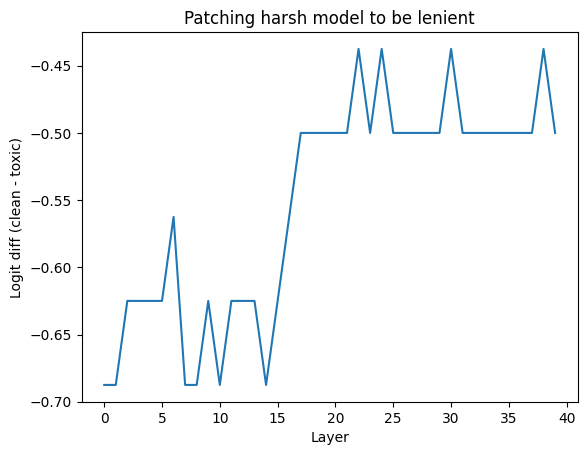

In [13]:
import matplotlib.pyplot as plt

# plt.title("Patching lenient model to be harsh")
plt.title("Patching harsh model to be lenient")
plt.xlabel("Layer")
plt.ylabel("Logit diff (clean - toxic)")
plt.plot(results)